In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# df = pd.read_csv('Image_classification_data/data_labels_mainData.csv')

In [2]:
import tensorflow
import pandas as pd
import numpy as np
print(tensorflow.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive/MyDrive/COSC2673")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/'MyDrive'/'COSC2673'

COSC2673_Assignment2.ipynb  Image_classification_data


In [5]:
! pwd

/content


In [6]:
locationMain = "https://raw.githubusercontent.com/s2105802-Nelson/COSC2673-A2-Group42/main/Image_classification_data/data_labels_mainData.csv?token=GHSAT0AAAAAAB66J46AHYJ3PZY64K27X4MQZCIRGJQ"
locationExtra = "https://raw.githubusercontent.com/s2105802-Nelson/COSC2673-A2-Group42/main/Image_classification_data/data_labels_extraData.csv?token=GHSAT0AAAAAAB66J46B5PRZN4MGBL36FXGUZCIRGWQ"

locationMain = "/content/drive/MyDrive/COSC2673/Image_classification_data/data_labels_mainData.csv"
locationExtra = "/content/drive/MyDrive/COSC2673/Image_classification_data/data_labels_extraData.csv"
dfMain = pd.read_csv(locationMain)
dfExtra = pd.read_csv(locationExtra)

In [7]:
dfMain.shape

(9896, 6)

In [8]:
dfMain.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [9]:
dfMain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [10]:
dfMain.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [11]:
dfMain['isCancerous'] = dfMain['isCancerous'].astype(str)

In [12]:
dfMain.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous     object
dtype: object

In [13]:
cancerous = dfMain[dfMain.isCancerous == '1']
benign = dfMain[dfMain.isCancerous == '0']
cancerous.shape

(4079, 6)

In [14]:
benign.shape

(5817, 6)

In [15]:
cancerous.index

Int64Index([ 449,  450,  451,  452,  453,  454,  455,  456,  457,  458,
            ...
            9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895],
           dtype='int64', length=4079)

In [16]:
# Load images from zip file
! cp /content/drive/'MyDrive'/'COSC2673'/Image_classification_data/patch_images.zip .
! unzip -q -o patch_images.zip
# ! rm patch

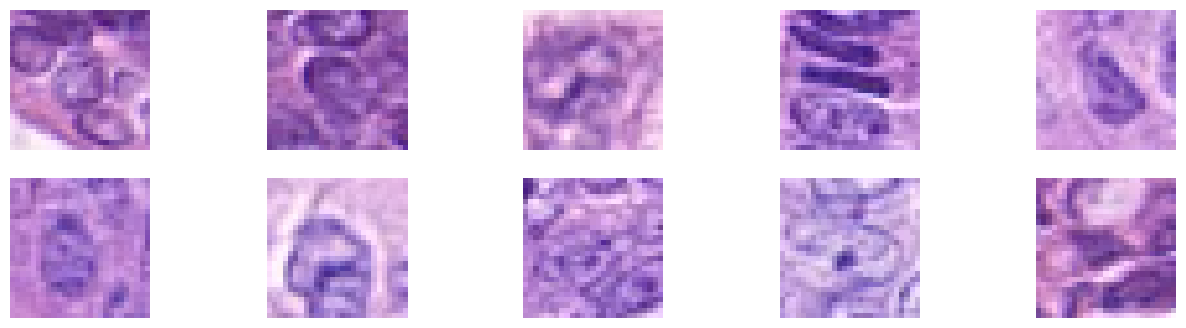

In [17]:
from PIL import Image

r_inx = np.random.choice(cancerous.index, 10)
rand_data = cancerous.loc[r_inx,'ImageName']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open('patch_images/'+image_path))
    plt.subplot(2,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')

# plt.title("Cancerous Cell Images")
plt.show()

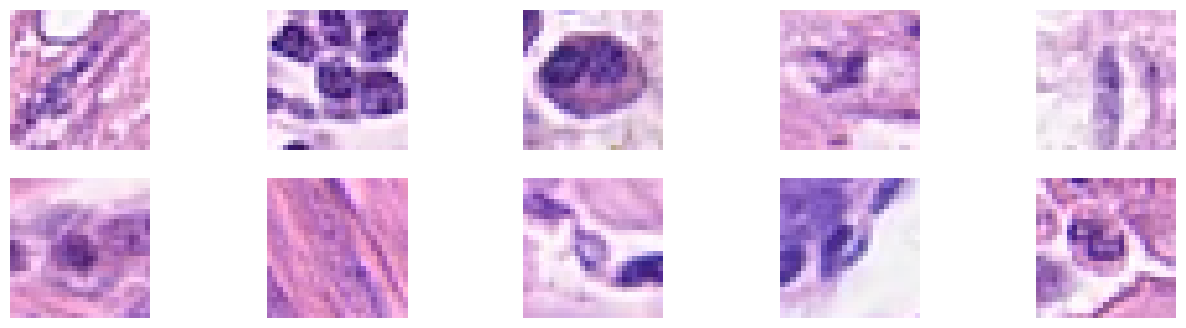

In [18]:
from PIL import Image

r_inx = np.random.choice(benign.index, 10)
rand_data = benign.loc[r_inx,'ImageName']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open('patch_images/'+image_path))
    plt.subplot(2,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')

# plt.title("Normal Cell Images") 
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
state = 1212125
train_val_df,test_df = train_test_split(dfMain,test_size=0.2,shuffle=True,random_state=state)

train_df, val_df = train_test_split(train_val_df, test_size=0.25, shuffle = True, random_state = state)

In [20]:
print("Shape of Training dataset:",train_df.shape)
print("Shape of Validation dataset:", val_df.shape)
print("Shape of testing dataset:", test_df.shape)


Shape of Training dataset: (5937, 6)
Shape of Validation dataset: (1979, 6)
Shape of testing dataset: (1980, 6)


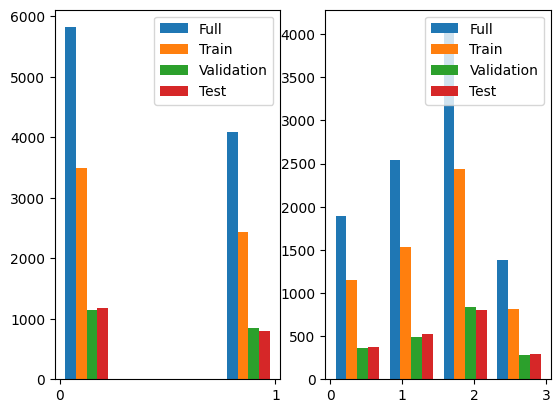

In [21]:
for i,col in enumerate(dfMain[['isCancerous','cellType']]):
  plt.subplot(1,2,i+1)
  plt.hist((dfMain[col],train_df[col],val_df[col],test_df[col])
  ,4,
  label=('Full','Train','Validation','Test'))
  plt.legend()
  # plt.hist(dfMain[col],alpha=0.6,color='b')
  # plt.hist(train_df[col],alpha=0.6,color='r')
  # plt.hist(val_df[col],alpha=0.6,color='y')
  # plt.hist(test_df[col],alpha=0.6,color='g')

# Buildilng A Neural Network Model for Cancerous Cell Detection

In [22]:
# 28 x 28 with 3 channels
INPUT_DIM = (28,28,3)
# Number of nodes in the hidden layer
HIDDEN_LAYER_DIM = 256
# Number of class to be predicted
OUTPUT_CLASSES = 2

In [23]:
# Using Sequential API to build the model as shown in the tutorial
import tensorflow as tf

model = tf.keras.Sequential([
    # Layer 1: Transform the image into correct format
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Layer 2: 256 nodes
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    # Layer 3: Work together with Layer 2 to produce 2 outputs
    # To determine the class of the image
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 256)               602368    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 602,882
Trainable params: 602,882
Non-trainable params: 0
_________________________________________________________________


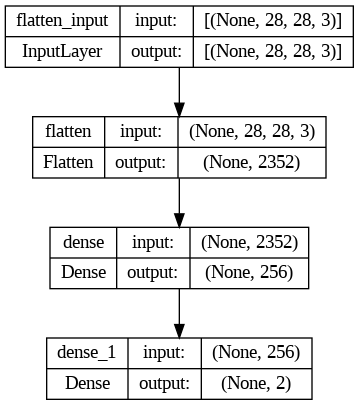

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compiling the model
Different parameters could be used to train the model, one of the parameters is to set the performance measure when training the data. 

As discussed, the metrics that are of importance in this task is precision and recall, thus, these metrics will be used

In [26]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale normalized the image from 0-255 to 0-1
# data_format shows the order of the shape (samples,height,width,channels)
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# flow_from_dataframe takes the dataframe and path 
# to generate batches of augmented data
#
# Data augmentation is a process of artificially increasing the amount of data 
# by generating new data points from existing data
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [ ]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

In [28]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

<ipython-input-28-3d796bb80333>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)


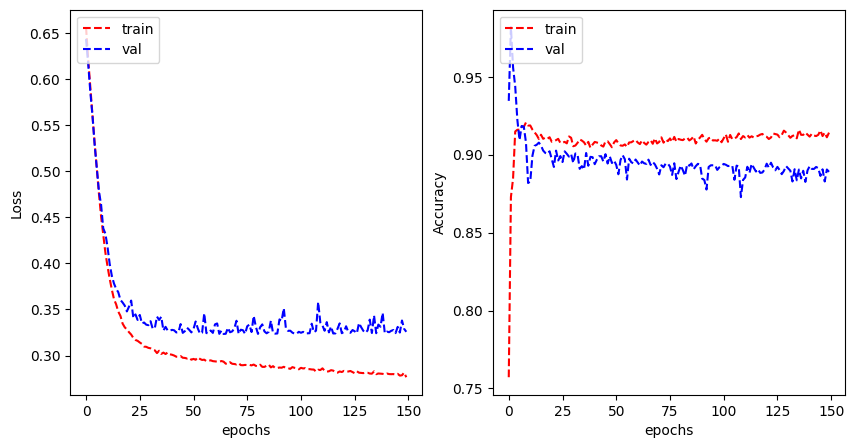

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['precision'], 'r--')
plt.plot(history.history['val_precision'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


In [31]:
model.evaluate(test_generator)

62/62 [==============================] - 2s 29ms/step - loss: 0.3150 - precision: 0.8929 - recall: 0.8207


[0.31499436497688293, 0.8928571343421936, 0.8207070827484131]